<a href="https://colab.research.google.com/github/nthanhkhang/ChatBots-to-Question-Answer-systems/blob/main/Task2_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I.Import Library

In [ ]:
import re
import pandas as pd
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from keras.layers import Input,Embedding,Bidirectional,LSTM,Dense,Concatenate
from keras.models import Model
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# II.Read Data

In [ ]:
import zipfile
with zipfile.ZipFile("DataChatbot.zip","r") as zf:
    zf.extractall('DataChatbot')
print(zf)

<zipfile.ZipFile [closed]>


In [ ]:
questions=[]
answers=[]
error=0
import glob
import os
path = 'DataChatbot'
for filename in glob.glob(os.path.join(path, '*.txt')):
   with open(os.path.join(os.getcwd(), filename), 'r') as f: # open in readonly mode
      for line in f:
        part = line.strip().strip('__eou_').split('__eou__')
        questions.append(", ".join(part[:-1]))
        answers.append(part[-1])
print('Question',questions[:5])
print('Answers',answers[:5])

Question ['bạn đã có việc làm chưa ? ', 'bạn đã có việc làm chưa ? ', 'bạn đã đi làm hay chưa? ', 'hiện tại bạn làm ở đâu? ', 'địa chỉ nơi làm việc của bạn ở đâu? ']
Answers [' chưa, mình đang thất nghiệp ', ' rồi, mình đang làm việc cho một công ty ', ' mình đã đi làm rồi ', ' hiện tại mình làm ở FPT software ', ' ở khu công nghệ cao ']


In [ ]:
df = pd.DataFrame(questions)
df.columns = ["Questions"]
df['Answers']=df['Questions'].apply(len)
df['Answers'] = pd.DataFrame(answers)
df.head()

,Questions,Answers
0,bạn đã có việc làm chưa ?,"chưa, mình đang thất nghiệp"
1,bạn đã có việc làm chưa ?,"rồi, mình đang làm việc cho một công ty"
2,bạn đã đi làm hay chưa?,mình đã đi làm rồi
3,hiện tại bạn làm ở đâu?,hiện tại mình làm ở FPT software
4,địa chỉ nơi làm việc của bạn ở đâu?,ở khu công nghệ cao


In [ ]:
print(df.shape)
print("="*60)
print(df.info())
print("="*60)
df.describe()

(5855, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5855 entries, 0 to 5854
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Questions  5855 non-null   object
 1   Answers    5855 non-null   object
dtypes: object(2)
memory usage: 91.6+ KB
None


,Questions,Answers
count,5855,5855
unique,4919,5067
top,bạn sinh năm nào?,
freq,25,86


In [ ]:
df.drop_duplicates(subset=['Questions'],inplace=True)
df.describe()

,Questions,Answers
count,4919,4919
unique,4919,4632
top,Thông thường từ nhà bạn đến trường tốn bào lâu?,
freq,1,77


In [ ]:
print(df.isnull().sum())
print('\n')
print(df.isnull().any())

Questions    0
Answers      0
dtype: int64


Questions    False
Answers      False
dtype: bool


In [ ]:
df.loc[55:60,:]

,Questions,Answers
55,bạn có đang đi làm không?,"có, hiện tại mình đang đi dạy thêm lập trình ..."
56,bạn đang làm ở đâu?,mình đang làm ở học viện công nghệ TEKY
57,bạn đi làm có vui không?,"chắc chắn là có rồi, làm việc mình thích cơ mà"
58,đồng nghiệp của bạn như thế nào?,từ sếp lớn cho tới các bạn giảng viên ai cũng...
59,lương của công việc hiện tại của bạn cao không?,lương cũng đủ để tiêu vặt
60,Mày đang làm cho công ty nào vậy ?,Tao đang làm cho một agency marketing nổi tiếng


# III.Text Preprocessing

## Lowercase

## Remove characters which are not english or numbers

In [ ]:
def pre_process(questions):
    stop_words = stopwords.words("english")
    
    # Remove non english words
    questions = [re.sub('[^a-z(c++)(c#)]', ' ', x.lower()) for x in questions]
    # Tokenlization
    questions_tokens = [nltk.word_tokenize(t) for t in questions]
    # Removing Stop Words
    questions_stop = [[t for t in tokens if (t not in stop_words) and (3 < len(t.strip()) < 15)]
                      for tokens in questions_tokens]
    
    questions_stop = pd.Series(questions_stop)
    return questions_stop

In [ ]:
# Initial preprocessing training data
# Initial preprocessing training data
questions = df['Questions']
questions_pp = pre_process(questions)
df

,Questions,Answers
0,bạn đã có việc làm chưa ?,"chưa, mình đang thất nghiệp"
2,bạn đã đi làm hay chưa?,mình đã đi làm rồi
3,hiện tại bạn làm ở đâu?,hiện tại mình làm ở FPT software
4,địa chỉ nơi làm việc của bạn ở đâu?,ở khu công nghệ cao
5,bạn làm công việc gì?,mình đang là kĩ sư phần mêm
...,...,...
5846,bạn có thích anime?,yes
5847,bạn thích xem phim không ?,Thích chứ ông
5852,"Vào mỗi dịp rảnh rỗi, em thường làm gì nhất",Em thường không làm gì cả
5853,"Sao không thử nghe nhạc xem, nó giúp em ổn hơn...",Em chỉ nghe lúc em muốn thôi


In [ ]:
df['decoder_input'] = df.Answers.apply(lambda x: 'sos '+x)
df['decoder_label'] = df.Answers.apply(lambda x: x+' eo>')
df.head()

,Questions,Answers,decoder_input,decoder_label
0,bạn đã có việc làm chưa ?,"chưa, mình đang thất nghiệp","sos chưa, mình đang thất nghiệp","chưa, mình đang thất nghiệp eo>"
2,bạn đã đi làm hay chưa?,mình đã đi làm rồi,sos mình đã đi làm rồi,mình đã đi làm rồi eo>
3,hiện tại bạn làm ở đâu?,hiện tại mình làm ở FPT software,sos hiện tại mình làm ở FPT software,hiện tại mình làm ở FPT software eo>
4,địa chỉ nơi làm việc của bạn ở đâu?,ở khu công nghệ cao,sos ở khu công nghệ cao,ở khu công nghệ cao eo>
5,bạn làm công việc gì?,mình đang là kĩ sư phần mêm,sos mình đang là kĩ sư phần mêm,mình đang là kĩ sư phần mêm eo>


In [ ]:
encoder_input = np.array(df.Questions)
decoder_input = np.array(df.decoder_input)
decoder_label = np.array(df.decoder_label)

n_rows = df.shape[0]
print(f"{n_rows} rows")

indices = np.arange(n_rows)
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_label = decoder_label[indices]

train_size = 0.9

train_encoder_input = encoder_input[:int(n_rows*train_size)]
train_decoder_input = decoder_input[:int(n_rows*train_size)]
train_decoder_label = decoder_label[:int(n_rows*train_size)]

test_encoder_input = encoder_input[int(n_rows*train_size):]
test_decoder_input = decoder_input[int(n_rows*train_size):]
test_decoder_label = decoder_label[int(n_rows*train_size):]

print(train_encoder_input.shape)
print(train_decoder_input.shape)
print(train_decoder_label.shape)

print(test_encoder_input.shape)
print(test_decoder_input.shape)
print(test_decoder_label.shape)

4919 rows
(4427,)
(4427,)
(4427,)
(492,)
(492,)
(492,)


In [ ]:
q_tok = Tokenizer()
q_tok.fit_on_texts(train_encoder_input)
print(len(q_tok.word_counts))

a_tok = Tokenizer()
a_tok.fit_on_texts(train_decoder_input)
a_tok.fit_on_texts(train_decoder_label)
print(len(a_tok.word_counts))

train_encoder_input = q_tok.texts_to_sequences(train_encoder_input)
test_encoder_input = q_tok.texts_to_sequences(test_encoder_input)

train_decoder_input = a_tok.texts_to_sequences(train_decoder_input)
test_decoder_input = a_tok.texts_to_sequences(test_decoder_input)

train_decoder_label = a_tok.texts_to_sequences(train_decoder_label)
test_decoder_label = a_tok.texts_to_sequences(test_decoder_label)

question_word_size = len(q_tok.word_counts)
question_vocab_size = question_word_size+1

answer_word_size = len(a_tok.word_counts)
answer_vocab_size = answer_word_size+1

2056
2984


maximum question sequence length >> 93
maximum answer sequence length >> 157


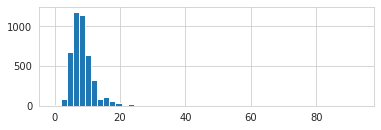

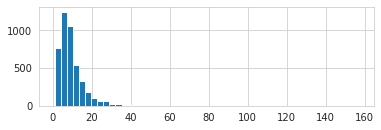

In [ ]:
question_lengths = [len(s) for s in train_encoder_input]
print(f"maximum question sequence length >> {np.max(question_lengths)}")

answer_lengths = [len(s) for s in train_decoder_input]
print(f"maximum answer sequence length >> {np.max(answer_lengths)}")

plt.subplot(2,1,1)
plt.hist(question_lengths,bins=50)
plt.show()

plt.subplot(2,1,2)
plt.hist(answer_lengths,bins=50)
plt.show()

In [ ]:
train_encoder_input = pad_sequences(train_encoder_input,padding='post')
train_decoder_input = pad_sequences(train_decoder_input,padding='post')
train_decoder_label = pad_sequences(train_decoder_label,padding='post')

print(train_encoder_input.shape)
print(train_decoder_input.shape)
print(train_decoder_label.shape)

question_sequence_size = train_encoder_input.shape[1]
answer_sequence_size = train_decoder_input.shape[1]

test_encoder_input = pad_sequences(test_encoder_input,padding='post',maxlen=question_sequence_size)
test_decoder_input = pad_sequences(test_decoder_input,padding='post',maxlen=answer_sequence_size)
test_decoder_label = pad_sequences(test_decoder_label,padding='post',maxlen=answer_sequence_size)

print(test_encoder_input.shape)
print(test_decoder_input.shape)
print(test_decoder_label.shape)

(4427, 93)
(4427, 157)
(4427, 157)
(492, 93)
(492, 157)
(492, 157)


# IV.Encoder-Decoder Model Attention

In [ ]:
embedding_size=256

In [ ]:
import tensorflow
from tensorflow.keras.layers import Attention

In [ ]:
#trainer model

hidden_size = 256

#encoder part start
encoder_input = Input(shape=[question_sequence_size])
# encoder_embedding = Embedding(question_vocab_size,embedding_size,mask_zero=True,trainable=False,weights=[question_embedding_matrix])
encoder_embedding = Embedding(question_vocab_size,embedding_size,mask_zero=True)
encoder_embedded = encoder_embedding(encoder_input)

lstm1 = LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3)
encoder_output1,_,_= lstm1(encoder_embedded)
lstm2 = LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3)
encoder_output2,_,_ = lstm2(encoder_output1)
lstm3 = LSTM(hidden_size,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3)
encoder_output3,encoder_h3,encoder_c3= lstm3(encoder_output2)
#encoder part done

#decoder part start
decoder_input = Input(shape=(None,))
# decoder_embedding = Embedding(answer_vocab_size,embedding_size,mask_zero=True,trainable=False,weights=[answer_embedding_matrix])
decoder_embedding = Embedding(answer_vocab_size,embedding_size,mask_zero=True)
decoder_embedded = decoder_embedding(decoder_input)

decoder_lstm = LSTM(hidden_size,return_sequences=True,return_state=True)
decoder_output,_,_ = decoder_lstm(decoder_embedded,initial_state=[encoder_h3,encoder_c3])

#Attention layer (query,value)
attn_layer = Attention()
attention_context = attn_layer([decoder_output,encoder_output3])

decoder_output = Concatenate(axis=-1)([decoder_output,attention_context])

dense1 = Dense(512,activation='relu')
decoder_output = dense1(decoder_output)

decoder_softmax = Dense(answer_vocab_size,activation='softmax')
decoder_output = decoder_softmax(decoder_output)

trainer = Model([encoder_input,decoder_input],decoder_output)
loss = tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
trainer.compile(loss=loss,optimizer='adam',metrics=['accuracy'])

In [ ]:
train_hist = trainer.fit([train_encoder_input,train_decoder_input],train_decoder_label,epochs=45,validation_split=0.1,batch_size=32)

Epoch 1/45
125/125 [==============================] - 198s 1s/step - loss: 0.4223 - accuracy: 0.1044 - val_loss: 0.3450 - val_accuracy: 0.1405
Epoch 2/45
125/125 [==============================] - 153s 1s/step - loss: 0.3543 - accuracy: 0.1312 - val_loss: 0.3353 - val_accuracy: 0.1517
Epoch 3/45
125/125 [==============================] - 154s 1s/step - loss: 0.3464 - accuracy: 0.1423 - val_loss: 0.3215 - val_accuracy: 0.1633
Epoch 4/45
125/125 [==============================] - 153s 1s/step - loss: 0.3319 - accuracy: 0.1579 - val_loss: 0.3130 - val_accuracy: 0.1794
Epoch 5/45
125/125 [==============================] - 152s 1s/step - loss: 0.2998 - accuracy: 0.1781 - val_loss: 0.3084 - val_accuracy: 0.1937
Epoch 6/45
125/125 [==============================] - 150s 1s/step - loss: 0.2846 - accuracy: 0.1940 - val_loss: 0.3058 - val_accuracy: 0.2134
Epoch 7/45
125/125 [==============================] - 150s 1s/step - loss: 0.2749 - accuracy: 0.2141 - val_loss: 0.3047 - val_accuracy: 0.2214

## 1.Generator model

In [ ]:
from tensorflow.keras.utils import plot_model

gen_encoder = Model(encoder_input,[encoder_output3,encoder_h3,encoder_c3])

gen_decoder_value_input = Input(shape=(question_sequence_size,hidden_size))
gen_decoder_h_input = Input(shape=[hidden_size])
gen_decoder_c_input = Input(shape=[hidden_size])

gen_decoder_embedded = decoder_embedding(decoder_input)
gen_decoder_output,gen_decoder_h,gen_decoder_c = decoder_lstm(gen_decoder_embedded,initial_state=[gen_decoder_h_input,gen_decoder_c_input])

## 2.Attention([querys,values])

In [ ]:
gen_attention_context = attn_layer([gen_decoder_output,gen_decoder_value_input])
gen_decoder_output = Concatenate(axis=-1)([gen_decoder_output,gen_attention_context])

gen_decoder_output = dense1(gen_decoder_output)
gen_decoder_output = decoder_softmax(gen_decoder_output)

gen_decoder = Model([decoder_input]+[gen_decoder_value_input,gen_decoder_h_input,gen_decoder_c_input],[gen_decoder_output]+[gen_decoder_h,gen_decoder_c])

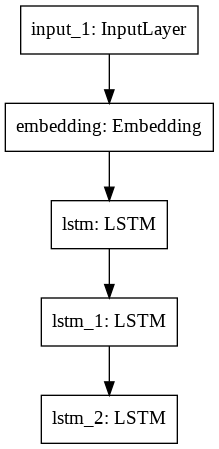

In [ ]:
plot_model(gen_encoder)

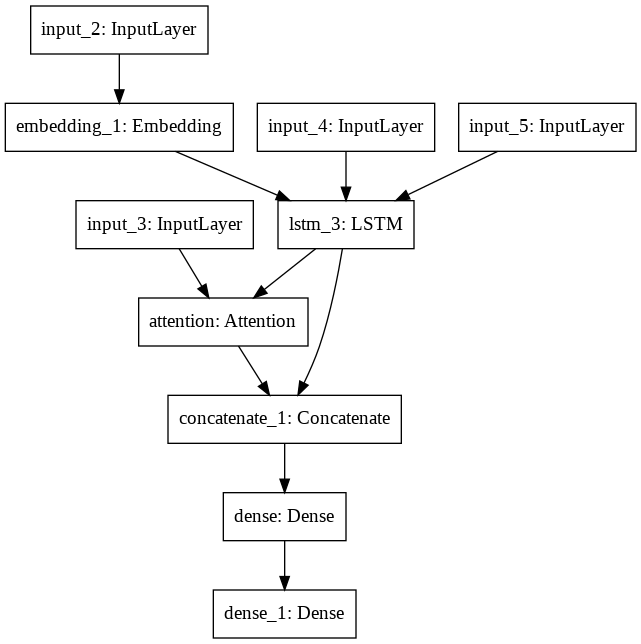

In [ ]:
plot_model(gen_decoder)

In [ ]:
def generate_from_input(encoder_input):
    values,h,c = gen_encoder.predict(encoder_input)
    
    decoder_seq = np.zeros((1,1))
    decoder_seq[0,0] = a_tok.word_index['sos']
    
    generated_sent = ''
    stop_condition= False
    
    while not stop_condition:
        output,h_state,c_state = gen_decoder.predict([decoder_seq]+[values,h,c])
        sampled_index = np.argmax(output[0,-1,:])
        sampled_word = a_tok.index_word[sampled_index]
        
        if sampled_word != 'eos':
            generated_sent = generated_sent + sampled_word + ' '
        
        if sampled_word == 'eos' or len(generated_sent) >= answer_sequence_size:
            stop_condition=True
        
        decoder_seq = np.zeros((1,1))
        decoder_seq[0,0] = sampled_index
        h,c = h_state,c_state
        
    return generated_sent.strip()
 
print(generate_from_input(train_encoder_input[24].reshape(1,question_sequence_size,-1)))
print(generate_from_input(train_encoder_input[1021].reshape(1,question_sequence_size,-1)))
print(generate_from_input(train_encoder_input[3001].reshape(1,question_sequence_size,-1)))

mình học trường đại học tôn đức thắng eo ngành tớ thuộc khoá 15 eo eo eo eo cũng đặt trình hay chuyên trình chất lượng cao và truyền thông dữ liệu eo eo eo khác
mình sinh ra ở thành phố hồ chí minh eo tài năng và trơn tru các vùng miền miền vin rẻ eo eo do bán trình ở bình edu eo do mình eo trình gì cũng có trình trung
tui cũng không biết nữa nhưng thú thật đi chỗ nào cũng thấy eo ốc eo cái đã đi eo đỉnh eo mới bán eo cũng được thì thú lắm eo địa chỉ cần phải đọc hợp với chăn


In [ ]:
def seq2question(encoder_input):
    ret=[q_tok.index_word[idx] for idx in encoder_input if idx != 0]
    return ' '.join(ret)

def seq2answer(decoder_input):
    ret = []
    for idx in decoder_input:
        if idx != 0:
            if a_tok.index_word[idx] != 'sos' and a_tok.index_word[idx] != 'eos':
                ret.append(a_tok.index_word[idx])
                
    return ' '.join(ret)

## 3.Results on train dataset

In [ ]:
sample_indices= [5,26,7,11,735,662,115,31,63]

for idx in sample_indices:
    generated_sent = generate_from_input(train_encoder_input[idx:idx+1])
    print(f"Question >> {seq2question(train_encoder_input[idx])}")
    print(f"Answer(Generated) >> {generated_sent}")
    print(f"Answer(Label) >> {seq2answer(train_decoder_input[idx])}")
    print("="*45)
    print("\n")

Question >> bạn nghĩ mình sẽ sống độc thân đến cuối đời
Answer(Generated) >> không đâu mình nghĩ bạn sẽ tìm được ai đó thôi hiện tại không thể nhưng tương lai có thể eo eo một việc của bạn eo của người đó nếu muốn rất người yêu mình eo
Answer(Label) >> không đâu mình nghĩ bạn sẽ tìm được ai đó thôi hiện tại không thể nhưng tương lai có thể


Question >> quê bạn có nhiều địa điểm du lịch không
Answer(Generated) >> quê tớ có nhiều lắm ví dụ như là quảng trường hồ chí minh quê bác núi quyết eo eo eo có có đặc sản khác nhau là một số khác nhau là nơi có có chỗ mua lớn ở đây
Answer(Label) >> quê tớ có nhiều lắm ví dụ như là quảng trường hồ chí minh quê bác núi quyết


Question >> chỗ cafe ưa thích mà bạn hay lui đến là ở đâu
Answer(Generated) >> thường thì mình thích ngồi những quán lề đường để cảm nhận nhịp sống của sài gòn eo sài gòn eo sài gòn eo sài gòn eo ngắm bạn nếu rất dễ thương và sài gòn đã
Answer(Label) >> thường thì mình thích ngồi những quán lề đường để cảm nhận nhịp sống của s

## 4.Results on test dataset

In [ ]:
sample_indices= [159,50,62,31,57]

for idx in sample_indices:
    generated_sent = generate_from_input(test_encoder_input[idx:idx+1])
    print(f"Question >> {seq2question(test_encoder_input[idx])}")
    print(f"Answer(Generated) >> {generated_sent}")
    print(f"Answer(Label) >> {seq2answer(test_decoder_input[idx])}")
    print("="*45)
    print("\n")

Question >> bạn có thường xuyên đi chơi bên ngoài với bạn bè mình không
Answer(Generated) >> có mình thường đến các show rap eo ngoài eo sạch là đi eo eo đi chơi eo đi chơi eo đi chơi eo đi học eo đi học về cntt eo eo mây mây mây nữa eo eo eo mây nữa
Answer(Label) >> có mình thường xuyên đi chơi với bạn bè mình


Question >> mày tên gì
Answer(Generated) >> quê mình ở tiền giang eo eo liên khai á eo eo eo số gì eo eo eo gì eo eo eo gì eo eo eo gì eo eo eo gì eo eo eo gì eo eo eo gì eo eo eo nữa eo eo eo nữa eo
Answer(Label) >> vũ


Question >> hiện bạn cảm thấy như thế nào
Answer(Generated) >> không bạn bè mình cực kỳ được yêu cùng lớp eo eo eo đi không eo hay đi eo eo đi học eo và đam mê của mình cũng rất vui tính eo rất vui với bạn eo eo không eo
Answer(Label) >> bình thường


Question >> bạn có quần này màu không
Answer(Generated) >> dạ cũng được con mới vào cũng không biết hay về sinh vào là noel eo eo eo eo sao không eo nữa eo eo eo sao eo eo eo sao eo eo eo sao eo eo eo sao eo e